# Introduction

# Airbnb Data Analysis

In this notebook, we will explore Airbnb data to uncover insights into shared accommodations. We will tackle the following key business questions:

1. **What are the peak seasons for bookings, and how do prices fluctuate throughout the year?**
2. **What are the key factors that influence the ratings of a listing?**
3. **How do review trends vary across different property types and locations?**

Let's begin by importing the necessary libraries and loading the data.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

# Path to extracted data
extract_path = 'data'

# Loading listings.csv, calendar.csv, reviews.csv files
listings_df = pd.read_csv(os.path.join(extract_path, 'listings.csv'))
calendar_df = pd.read_csv(os.path.join(extract_path, 'calendar.csv'))
reviews_df = pd.read_csv(os.path.join(extract_path, 'reviews.csv'))

# Displaying the first few rows of each DataFrame
listings_df.head(), calendar_df.head(), reviews_df.head()


(        id                           listing_url       scrape_id last_scraped  \
 0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
 1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
 2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
 3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
 4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   
 
                                   name  \
 0         Stylish Queen Anne Apartment   
 1   Bright & Airy Queen Anne Apartment   
 2  New Modern House-Amazing water view   
 3                   Queen Anne Chateau   
 4       Charming craftsman 3 bdm house   
 
                                              summary  \
 0                                                NaN   
 1  Chemically sensitive? We've removed the irrita...   
 2  New modern house built in 2013.  Spectacular s...   
 3  A charming apa

### Preprocessing

In [9]:
# Function to clean and preprocess the calendar data
def preprocess_calendar_data(df):
    # Removing the dollar sign and commas from the price column
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

    # Converting the date column to a datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Converting the available column to a boolean format (True for available, False for not available)
    df['available'] = df['available'] == 't'

    return df

# Applying the preprocessing function to the calendar DataFrame
calendar_df_cleaned = preprocess_calendar_data(calendar_df.copy())

# Displaying the first few rows of the cleaned DataFrame
calendar_df_cleaned.head()


,listing_id,date,available,price
0,241032,2016-01-04,True,85.0
1,241032,2016-01-05,True,85.0
2,241032,2016-01-06,False,NaN
3,241032,2016-01-07,False,NaN
4,241032,2016-01-08,False,NaN


### Business Question 1: Peak Seasons and Price Fluctuations

#### Peak Booking Seasons

We'll start by analyzing the booking patterns to identify peak seasons.


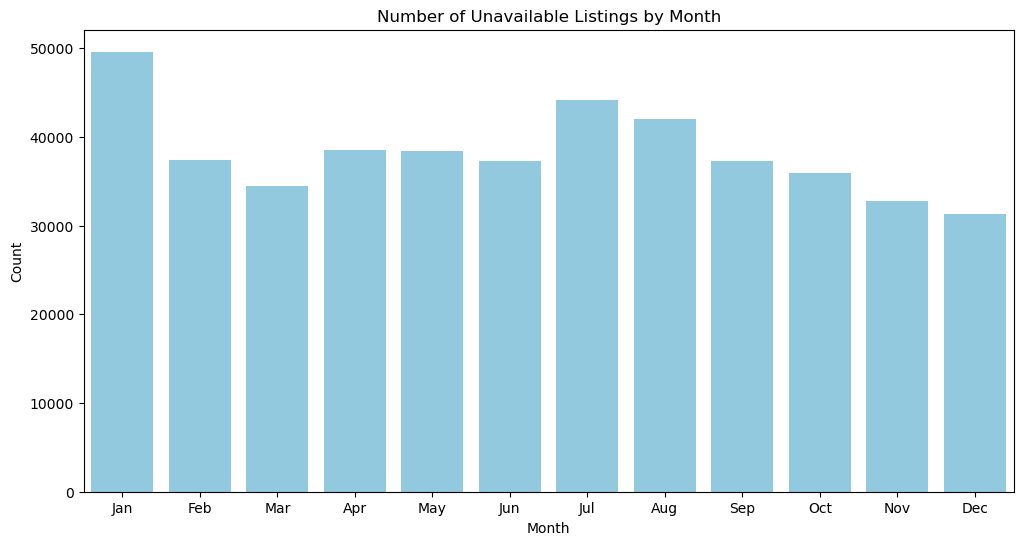

In [10]:
# Importing necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting the month from the date
calendar_df_cleaned['month'] = calendar_df_cleaned['date'].dt.month

# Grouping by month and counting the number of unavailable listings
unavailable_by_month = calendar_df_cleaned[~calendar_df_cleaned['available']].groupby('month').size().reset_index(name='count')

# Plotting the unavailable listings by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='count', data=unavailable_by_month, color='skyblue')
plt.title('Number of Unavailable Listings by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


#### Price Trends

Next, we'll explore how prices fluctuate throughout the year.


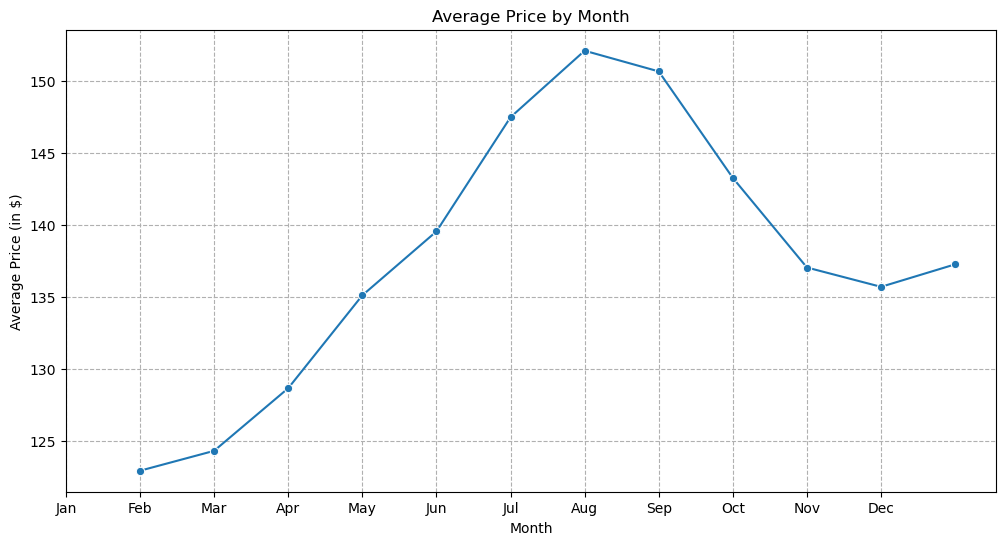

In [14]:
# Grouping by month and calculating the average price for available listings
average_price_by_month = calendar_df_cleaned[calendar_df_cleaned['available']].groupby('month')['price'].mean().reset_index()

# Plotting the average price by month
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='price', data=average_price_by_month, marker='o')
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Price (in $)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--')
plt.show()


#### Insights

- **For Hosts:** Tailor pricing strategies to seasonal demand.
- **For Guests:** Plan bookings during off-peak seasons to find lower prices.


### Business Question 2: Influencing Factors for Ratings

#### Data Preprocessing

We'll start by selecting relevant features and preprocessing the data to understand the key factors influencing ratings.


In [15]:
# Function to clean and preprocess the listings data
def preprocess_listings_data(df):
    # Selecting a subset of columns that are likely to influence the rating of a listing
    columns_to_keep = ['host_response_time', 'host_response_rate', 'host_is_superhost',
                       'property_type', 'room_type', 'accommodates', 'bathrooms',
                       'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating']
    df = df[columns_to_keep]

    # Removing the percentage sign from the host_response_rate column and converting it to a float
    df['host_response_rate'] = df['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)

    # Removing the dollar sign and commas from the price column and converting it to a float
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

    # Converting the host_is_superhost column to a boolean format
    df['host_is_superhost'] = df['host_is_superhost'] == 't'

    return df

# Applying the preprocessing function to the listings DataFrame
listings_df_cleaned = preprocess_listings_data(listings_df.copy())

# Displaying the first few rows of the cleaned DataFrame
listings_df_cleaned.head()


,host_response_time,host_response_rate,host_is_superhost,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,within a few hours,96.0,False,Apartment,Entire home/apt,4,1.0,1.0,1.0,85.0,207,95.0
1,within an hour,98.0,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,150.0,43,96.0
2,within a few hours,67.0,False,House,Entire home/apt,11,4.5,5.0,7.0,975.0,20,97.0
3,NaN,NaN,False,Apartment,Entire home/apt,3,1.0,0.0,2.0,100.0,0,NaN
4,within an hour,100.0,False,House,Entire home/apt,6,2.0,3.0,3.0,450.0,38,92.0


#### Correlation Analysis

We'll now analyze the correlations between different features and review scores to identify the key factors influencing ratings.


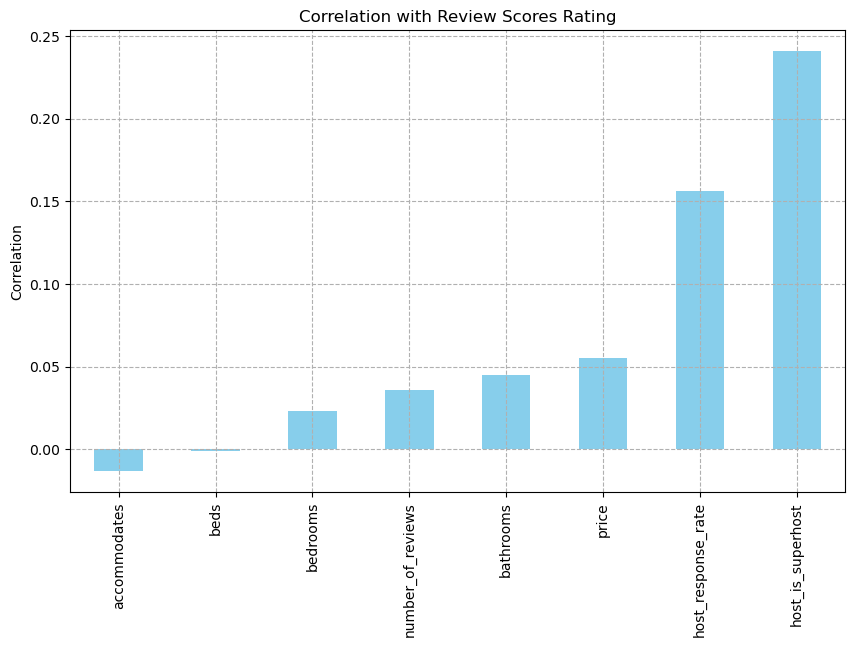

In [16]:
# Calculating the correlation with the review_scores_rating column
correlations = listings_df_cleaned.corr()['review_scores_rating'].sort_values()

# Removing the review_scores_rating correlation with itself
correlations = correlations.drop('review_scores_rating')

# Plotting the correlations
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar', color='skyblue')
plt.title('Correlation with Review Scores Rating')
plt.ylabel('Correlation')
plt.grid(True, linestyle='--')
plt.show()


#### Insights

- **Number of Reviews:** More reviews might slightly dampen ratings.
- **Superhost Status:** Higher ratings often accompany superhost status.
- **Property Size and Capacity:** Bigger properties generally fare better.
- **Host Responsiveness:** Quick replies please guests.
- **Price:** Higher prices may reflect better experiences.


### Business Question 3: Review Trends Across Property Types and Locations

#### Data Processing

In [18]:
# Selecting relevant columns from the listings DataFrame for the merge
listings_columns_for_merge = ['id', 'property_type', 'neighbourhood_cleansed', 'latitude', 'longitude']
listings_for_merge = listings_df[listings_columns_for_merge]

# Renaming the 'id' column to 'listing_id' in the listings DataFrame to match the reviews DataFrame
listings_for_merge.rename(columns={'id': 'listing_id'}, inplace=True)

# Merging the reviews and selected listings data on the 'listing_id' column
merged_reviews_data = pd.merge(reviews_df, listings_for_merge, on='listing_id', how='left')

# Displaying the first few rows of the merged data
merged_reviews_data.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments,property_type,neighbourhood_cleansed,latitude,longitude
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,Apartment,Lower Queen Anne,47.62621,-122.360147
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,Apartment,Lower Queen Anne,47.62621,-122.360147
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",Apartment,Lower Queen Anne,47.62621,-122.360147
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,Apartment,Lower Queen Anne,47.62621,-122.360147
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,Apartment,Lower Queen Anne,47.62621,-122.360147


#### Review Frequency Across Property Types

We'll explore how different property types receive reviews to understand customer preferences.


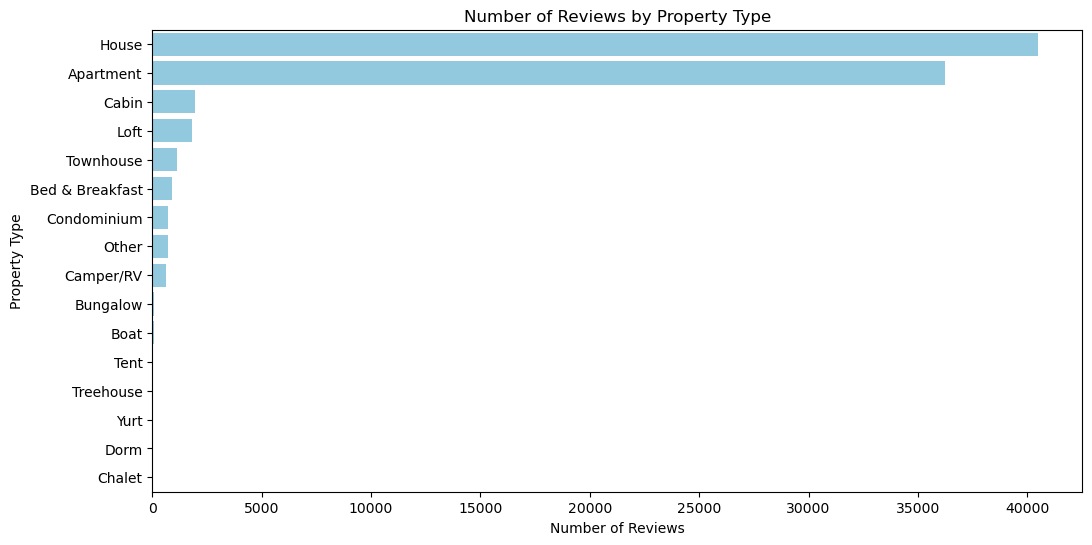

In [19]:
# Counting the number of reviews by property type
reviews_by_property_type = merged_reviews_data['property_type'].value_counts().reset_index()
reviews_by_property_type.columns = ['property_type', 'count']

# Plotting the number of reviews by property type
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='property_type', data=reviews_by_property_type, color='skyblue')
plt.title('Number of Reviews by Property Type')
plt.xlabel('Number of Reviews')
plt.ylabel('Property Type')
plt.show()


#### Average Ratings Across Neighborhoods

Next, we'll investigate how different neighborhoods or areas are rated by guests.


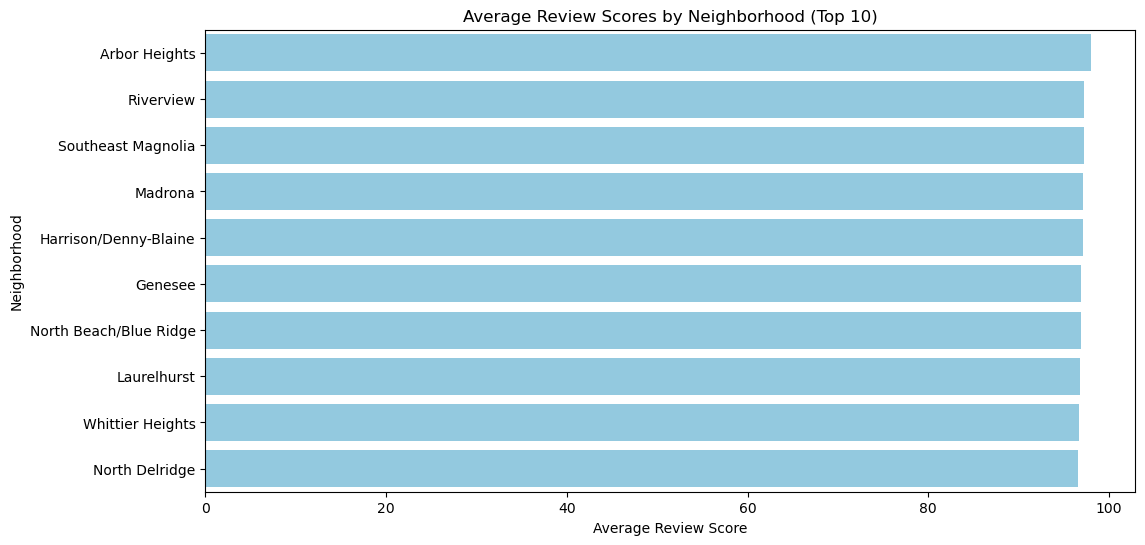

In [20]:
# Selecting relevant columns from the listings DataFrame for neighborhood analysis
neighborhood_ratings = listings_df[['neighbourhood_cleansed', 'review_scores_rating']]

# Calculating the average review scores by neighborhood
average_ratings_by_neighborhood = neighborhood_ratings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().reset_index()

# Sorting by average rating
average_ratings_by_neighborhood = average_ratings_by_neighborhood.sort_values(by='review_scores_rating', ascending=False)

# Plotting the average review scores by neighborhood (Top 10 neighborhoods)
plt.figure(figsize=(12, 6))
sns.barplot(x='review_scores_rating', y='neighbourhood_cleansed', data=average_ratings_by_neighborhood.head(10), color='skyblue')
plt.title('Average Review Scores by Neighborhood (Top 10)')
plt.xlabel('Average Review Score')
plt.ylabel('Neighborhood')
plt.show()


#### Seasonal Trends in Reviews

Finally, we'll examine how review patterns change throughout the year.


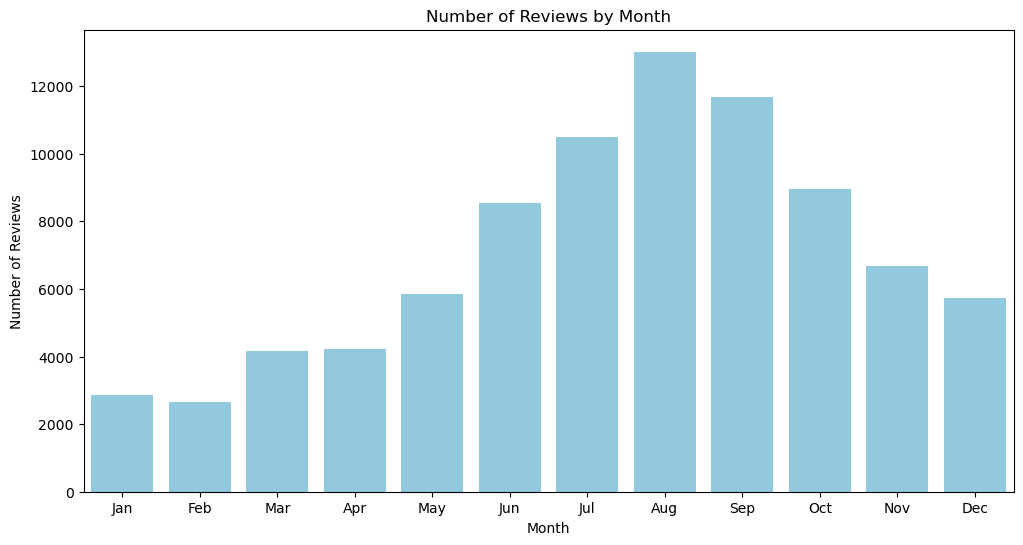

In [21]:
# Converting the date column to a datetime format
merged_reviews_data['date'] = pd.to_datetime(merged_reviews_data['date'])

# Extracting the month from the date
merged_reviews_data['month'] = merged_reviews_data['date'].dt.month

# Counting the number of reviews by month
reviews_by_month = merged_reviews_data['month'].value_counts().sort_index().reset_index()
reviews_by_month.columns = ['month', 'count']

# Plotting the number of reviews by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='count', data=reviews_by_month, color='skyblue')
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


#### Insights

- **For Hosts:**
   - **Embrace Popular Choices:** Focus on property types that resonate with guests.
   - **Location, Location, Location:** Enhance experiences in top-rated areas.
   - **Seasonal Sensitivity:** Cater to seasonal trends.

- **For Travelers:**
   - **Choose Wisely:** Seek popular property types and highly-rated neighborhoods.
   - **Seasonal Adventures:** Align travels with seasonal insights.


### Conclusion

This exploration has provided valuable insights into the dynamics of shared accommodations on platforms like Airbnb. Whether you're a host looking to optimize your listings or a traveler planning your next adventure, these data-driven insights offer a roadmap to delightful experiences. Happy hosting and happy travels!
